Edited by Wanyu

27 Sep

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import os

import sys
current_dir = os.getcwd()
scripts_path = os.path.join(current_dir, '../../scripts')
sys.path.append(os.path.abspath(scripts_path))
import preprocess_function as process

In [2]:
# Path to domain data and SA2
base_dir = '../../data/'
raw_dir = os.path.join(base_dir, 'raw')
curated_dir = os.path.join(base_dir, 'curated')

SA2_shapefile_path = f"{raw_dir}/ABS_SA2/SA2_2021_AUST_GDA2020.shp"
LGA_shapefile_path = f"{raw_dir}/ABS_LGA/LGA_2024_AUST_GDA94.shp"

past_folder = os.path.join(raw_dir, 'merge_past_forcasting_data') 

income_path = f"{past_folder}/merged_income_data.csv"
population_path = f"{past_folder}/merged_population_data.csv"
crime_path = f"{past_folder}/merged_crime_data.csv"

property_data_path = f"{raw_dir}/domain/all_properties_preprocessed.csv"

In [3]:
# Load in datasets
SA2_gdf = gpd.read_file(SA2_shapefile_path)
LGA_gdf = gpd.read_file(LGA_shapefile_path)
property_data = pd.read_csv(property_data_path)

In [4]:
try:
    income = pd.read_csv(
        income_path, 
        encoding='utf-8', 
        na_values=['', ' ', 'NA', 'NaN']
    )
except Exception as e:
    print("Error loading income data:", e)

In [5]:
try:
    population = pd.read_csv(
        population_path, 
        encoding='utf-8', 
        na_values=['', ' ', 'NA', 'NaN']
    )
except Exception as e:
    print("Error loading population data:", e)

In [6]:
try:
    crime = pd.read_csv(
        crime_path, 
        encoding='utf-8', 
        na_values=['', ' ', 'NA', 'NaN']
    )
except Exception as e:
    print("Error loading crime data:", e)

In [7]:
try:
    property = pd.read_csv(
        property_data_path, 
        encoding='utf-8', 
        na_values=['', ' ', 'NA', 'NaN']
    )
except Exception as e:
    print("Error loading property data:", e)

In [8]:
print(population.head())
print(population.info())

# Check specific columns for unexpected NaN values
print("Missing values per column:\n", population.isna().sum())

   Year     SA2 code  Population
0  2015  201011001.0     11039.0
1  2015  201011002.0     12300.0
2  2015  201011005.0      7191.0
3  2015  201011006.0      6846.0
4  2015  201011007.0      3966.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6786 entries, 0 to 6785
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        6786 non-null   int64  
 1   SA2 code    6786 non-null   float64
 2   Population  6786 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 159.2 KB
None
Missing values per column:
 Year          0
SA2 code      0
Population    0
dtype: int64


In [9]:
print(income.head())
print(income.info())

# Check specific columns for unexpected NaN values
print("Missing values per column:\n", income.isna().sum())

   Year     SA2 Code             Income
0  2015  201011001.0  48752.40000000037
1  2015  201011002.0  48902.39999999991
2  2015  201011005.0            47100.0
3  2015  201011006.0  44493.80000000028
4  2015  201011007.0  45737.29999999981
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6786 entries, 0 to 6785
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      6786 non-null   int64  
 1   SA2 Code  6786 non-null   float64
 2   Income    6786 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 159.2+ KB
None
Missing values per column:
 Year        0
SA2 Code    0
Income      0
dtype: int64


In [10]:
print(crime.head())
print(crime.info())

# Check specific columns for unexpected NaN values
print("Missing values per column:\n", crime.isna().sum())

   Year Local Government Area  Incidents Recorded
0  2015                Alpine               299.0
1  2015                Ararat               860.0
2  2015              Ballarat              7825.0
3  2015               Banyule              6577.0
4  2015            Bass Coast              1895.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   1053 non-null   int64  
 1   Local Government Area  1053 non-null   object 
 2   Incidents Recorded     1053 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.8+ KB
None
Missing values per column:
 Year                     0
Local Government Area    0
Incidents Recorded       0
dtype: int64


In [11]:
print(property.head())
print(property.info())

# Check specific columns for unexpected NaN values
print("Missing values per column:\n", property.isna().sum())

   Unnamed: 0                                            Address    Cost  \
0           0        8/90 Hambleton Street, Middle Park VIC 3206   410.0   
1           1            3/33 Bevan Street, Albert Park VIC 3206   550.0   
2           3        7/7-9 Faussett Street, Albert Park VIC 3206   490.0   
3           4                               Albert Park VIC 3206  1280.0   
4           5  214/363 Beaconsfield Parade, Middle Park VIC 3206   350.0   

  Property Type  Bedrooms  Bathrooms   Latitude   Longitude  \
0     Apartment         1          1 -37.847553  144.960477   
1     Apartment         1          1 -37.839959  144.956373   
2     Apartment         1          1 -37.841670  144.955332   
3     Apartment         1          1 -37.843861  144.951454   
4     Apartment         1          1 -37.854035  144.961308   

  Closest Gov Secondary School Gov Secondary Distance Age under 20 Age 20-39  \
0          Albert Park College            1.2 km away          36%       15%   
1   

# Combine data with all API calculated distance to locations

In [12]:
distance_files = {
    "CBD Distance": "../../data/raw/domain/cbd_distance.csv",
    "Train Distance": "../../data/raw/domain/train_distance.csv",
    "Electricity Distance": "../../data/raw/domain/elec_distance.csv",
    "Hospital Distance": "../../data/raw/domain/hospital_distance.csv",
    "Library Distance": "../../data/raw/domain/lib_distance.csv",
    "Park Distance": "../../data/raw/domain/park_distance.csv",
    "Tourist Attraction Distance": "../../data/raw/domain/tour_distance.csv",
    "Grocery Distance": "../../data/raw/domain/shop_distance.csv"
}

In [13]:
# Join
for column_name, file_path in distance_files.items():
    # Load the CSV file
    new_column_data = pd.read_csv(file_path)
    
    # Check if the number of rows matches the filtered_merge DataFrame
    if len(new_column_data) == len(property):
        # Add the new column to the filtered_merge DataFrame
        property[column_name] = new_column_data.iloc[:, 0]
    else:
        print(f"Warning: File {file_path} has a different number of rows and was not added.")


# Feature Generation - 'Year' on property_data
Assumption: There is no large change on the public facilities

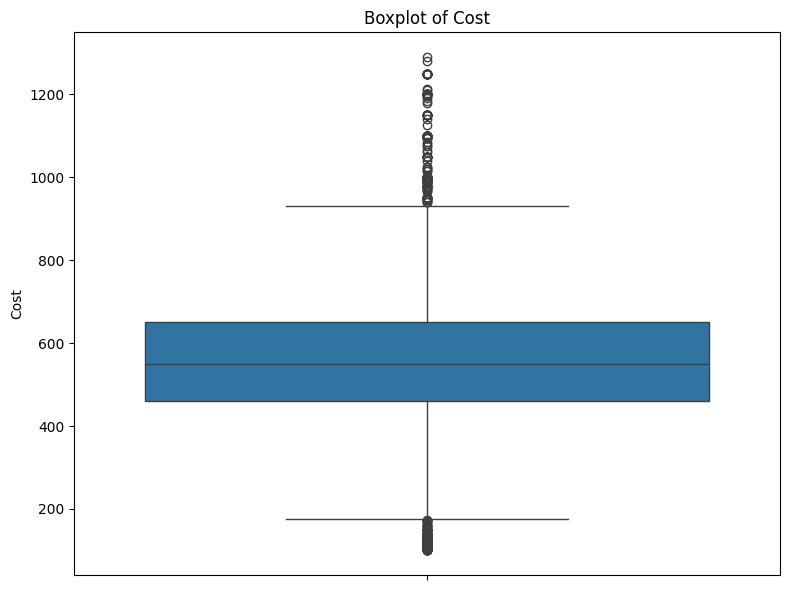

In [14]:
property.shape
process.plot_boxplots(property, 'Cost')

In [15]:
# Before add 'Year' and generate records belongs to different years, remove the outlier on 'Cost'
property = process.outlier_remover(property, 'Cost')
property.shape

(6221, 23)

In [16]:
property = property.drop(columns=['Unnamed: 0'])
property.columns

Index(['Address', 'Cost', 'Property Type', 'Bedrooms', 'Bathrooms', 'Latitude',
       'Longitude', 'Closest Gov Secondary School', 'Gov Secondary Distance',
       'Age under 20', 'Age 20-39', 'Age 40-59', 'Age 60+', 'Postcode',
       'CBD Distance', 'Train Distance', 'Electricity Distance',
       'Hospital Distance', 'Library Distance', 'Park Distance',
       'Tourist Attraction Distance', 'Grocery Distance'],
      dtype='object')

In [17]:
# list of year
years = list(range(2015, 2028)) 
property_year = pd.DataFrame(np.repeat(property.values, len(years), axis=0), columns=property.columns)

# add 'Year' feature on property_Data
property_year['Year'] = np.tile(years, len(property))

property_year.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80873 entries, 0 to 80872
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Address                       80873 non-null  object
 1   Cost                          80873 non-null  object
 2   Property Type                 80873 non-null  object
 3   Bedrooms                      80873 non-null  object
 4   Bathrooms                     80873 non-null  object
 5   Latitude                      80873 non-null  object
 6   Longitude                     80873 non-null  object
 7   Closest Gov Secondary School  70395 non-null  object
 8   Gov Secondary Distance        70395 non-null  object
 9   Age under 20                  79924 non-null  object
 10  Age 20-39                     79924 non-null  object
 11  Age 40-59                     79924 non-null  object
 12  Age 60+                       79924 non-null  object
 13  Postcode        

In [18]:
# Set the 'Cost' column to NaN for all records where the 'Year' is not 2024
property_year['Cost'] = np.where(property_year['Year'] == 2024, property_year['Cost'], np.nan)

# Merge property_data and income_data, population_data

In [19]:
# Fix SA2 code being float issue
population['SA2 code'] = population['SA2 code'].apply(lambda x: str(int(x)) if not pd.isna(x) else '')

# Inspect the corrected 'SA2  code' values
print("Corrected 'SA2  code' values:", population['SA2 code'].unique()[:10])

Corrected 'SA2  code' values: ['201011001' '201011002' '201011005' '201011006' '201011007' '201011008'
 '201011481' '201011482' '201011483' '201011484']


In [20]:
# Fix SA2 code being float issue
income['SA2 Code'] = income['SA2 Code'].apply(lambda x: str(int(x)) if not pd.isna(x) else '')

# Inspect the corrected 'SA2  code' values
print("Corrected 'SA2  code' values:", income['SA2 Code'].unique()[:10])

Corrected 'SA2  code' values: ['201011001' '201011002' '201011005' '201011006' '201011007' '201011008'
 '201011481' '201011482' '201011483' '201011484']


In [21]:
# Modify property to prepare join with shapefile
property_year['geometry'] = property_year.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
property_gdf = gpd.GeoDataFrame(property_year, geometry='geometry', crs=SA2_gdf.crs)

In [22]:
# Join the SA2_code into property_data
mapped_properties = gpd.sjoin(property_gdf, SA2_gdf, how='left', predicate='within')
mapped_properties['SA2_CODE21'] = mapped_properties['SA2_CODE21'].astype(str)

mapped_properties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 80873 entries, 0 to 80872
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Address                       80873 non-null  object  
 1   Cost                          6221 non-null   object  
 2   Property Type                 80873 non-null  object  
 3   Bedrooms                      80873 non-null  object  
 4   Bathrooms                     80873 non-null  object  
 5   Latitude                      80873 non-null  object  
 6   Longitude                     80873 non-null  object  
 7   Closest Gov Secondary School  70395 non-null  object  
 8   Gov Secondary Distance        70395 non-null  object  
 9   Age under 20                  79924 non-null  object  
 10  Age 20-39                     79924 non-null  object  
 11  Age 40-59                     79924 non-null  object  
 12  Age 60+                       79924 non-nul

In [23]:
mapped_properties.columns

Index(['Address', 'Cost', 'Property Type', 'Bedrooms', 'Bathrooms', 'Latitude',
       'Longitude', 'Closest Gov Secondary School', 'Gov Secondary Distance',
       'Age under 20', 'Age 20-39', 'Age 40-59', 'Age 60+', 'Postcode',
       'CBD Distance', 'Train Distance', 'Electricity Distance',
       'Hospital Distance', 'Library Distance', 'Park Distance',
       'Tourist Attraction Distance', 'Grocery Distance', 'Year', 'geometry',
       'index_right', 'SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21',
       'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21',
       'GCC_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21',
       'AREASQKM21', 'LOCI_URI21'],
      dtype='object')

In [24]:
# Merge the spatially joined property_data with population_data and income_data base on 'Year' and 'SA2_code'
# merge property_data and population_data
df_merged = pd.merge(mapped_properties, population, left_on=['Year', 'SA2_CODE21'], right_on=['Year', 'SA2 code'], how='left')


# merge property_population_data and income_data
df_merged = pd.merge(df_merged, income, left_on=['Year', 'SA2_CODE21'], right_on=['Year', 'SA2 Code'], how='left')

df_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80873 entries, 0 to 80872
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Address                       80873 non-null  object  
 1   Cost                          6221 non-null   object  
 2   Property Type                 80873 non-null  object  
 3   Bedrooms                      80873 non-null  object  
 4   Bathrooms                     80873 non-null  object  
 5   Latitude                      80873 non-null  object  
 6   Longitude                     80873 non-null  object  
 7   Closest Gov Secondary School  70395 non-null  object  
 8   Gov Secondary Distance        70395 non-null  object  
 9   Age under 20                  79924 non-null  object  
 10  Age 20-39                     79924 non-null  object  
 11  Age 40-59                     79924 non-null  object  
 12  Age 60+                       79924 no

In [25]:
df_merged.columns

Index(['Address', 'Cost', 'Property Type', 'Bedrooms', 'Bathrooms', 'Latitude',
       'Longitude', 'Closest Gov Secondary School', 'Gov Secondary Distance',
       'Age under 20', 'Age 20-39', 'Age 40-59', 'Age 60+', 'Postcode',
       'CBD Distance', 'Train Distance', 'Electricity Distance',
       'Hospital Distance', 'Library Distance', 'Park Distance',
       'Tourist Attraction Distance', 'Grocery Distance', 'Year', 'geometry',
       'index_right', 'SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21',
       'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21',
       'GCC_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21',
       'AREASQKM21', 'LOCI_URI21', 'SA2 code', 'Population', 'SA2 Code',
       'Income'],
      dtype='object')

In [26]:
# select features
drop_columns = ['geometry', 'index_right', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21',
       'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21',
       'GCC_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21',
       'AREASQKM21', 'LOCI_URI21', 'SA2 code', 'SA2 Code']

# Drop useless features
df_filtered = df_merged.drop(drop_columns, axis=1)
df_filtered.columns
df_filtered.shape

(80873, 26)

In [27]:
# Modify property to prepare join with shapefile
df_filtered['geometry'] = df_filtered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
property_gdf_filtered = gpd.GeoDataFrame(df_filtered, geometry='geometry', crs=LGA_gdf.crs)

In [28]:
# Join
df_filtered = gpd.sjoin(property_gdf_filtered, LGA_gdf, how='left', predicate='within')
df_filtered['LGA_NAME24'] = df_filtered['LGA_NAME24'].astype(str)

df_filtered.columns

Index(['Address', 'Cost', 'Property Type', 'Bedrooms', 'Bathrooms', 'Latitude',
       'Longitude', 'Closest Gov Secondary School', 'Gov Secondary Distance',
       'Age under 20', 'Age 20-39', 'Age 40-59', 'Age 60+', 'Postcode',
       'CBD Distance', 'Train Distance', 'Electricity Distance',
       'Hospital Distance', 'Library Distance', 'Park Distance',
       'Tourist Attraction Distance', 'Grocery Distance', 'Year', 'SA2_CODE21',
       'Population', 'Income', 'geometry', 'index_right', 'LGA_CODE24',
       'LGA_NAME24', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21',
       'AREASQKM', 'LOCI_URI21'],
      dtype='object')

In [29]:
crime['Local Government Area'] = crime['Local Government Area'].astype(str)
crime['Local Government Area'] = crime['Local Government Area'].str.strip()
df_filtered['LGA_NAME24'] = df_filtered['LGA_NAME24'].str.strip()


In [30]:
# Merge the spatially joined data with property and crime data using the correct column names
df_filtered = pd.merge(
    df_filtered, 
    crime, 
    left_on=['Year', 'LGA_NAME24'], 
    right_on=['Year', 'Local Government Area'], 
    how='left'
    )


In [31]:
drop_columns = ['geometry', 'index_right',  'LGA_NAME24', 'STE_CODE21', 
                'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM', 'LOCI_URI21',
                'Local Government Area']

# Filter the merged data to keep only the selected columns
filtered_merge = df_filtered.drop(drop_columns, axis=1)
filtered_merge.columns

Index(['Address', 'Cost', 'Property Type', 'Bedrooms', 'Bathrooms', 'Latitude',
       'Longitude', 'Closest Gov Secondary School', 'Gov Secondary Distance',
       'Age under 20', 'Age 20-39', 'Age 40-59', 'Age 60+', 'Postcode',
       'CBD Distance', 'Train Distance', 'Electricity Distance',
       'Hospital Distance', 'Library Distance', 'Park Distance',
       'Tourist Attraction Distance', 'Grocery Distance', 'Year', 'SA2_CODE21',
       'Population', 'Income', 'LGA_CODE24', 'Incidents Recorded'],
      dtype='object')

In [32]:
filtered_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80873 entries, 0 to 80872
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Address                       80873 non-null  object 
 1   Cost                          6221 non-null   object 
 2   Property Type                 80873 non-null  object 
 3   Bedrooms                      80873 non-null  object 
 4   Bathrooms                     80873 non-null  object 
 5   Latitude                      80873 non-null  object 
 6   Longitude                     80873 non-null  object 
 7   Closest Gov Secondary School  70395 non-null  object 
 8   Gov Secondary Distance        70395 non-null  object 
 9   Age under 20                  79924 non-null  object 
 10  Age 20-39                     79924 non-null  object 
 11  Age 40-59                     79924 non-null  object 
 12  Age 60+                       79924 non-null  object 
 13  P

In [33]:
filtered_merge.iloc[1]

Address                         8/90 Hambleton Street, Middle Park VIC 3206
Cost                                                                    NaN
Property Type                                                     Apartment
Bedrooms                                                                  1
Bathrooms                                                                 1
Latitude                                                         -37.847553
Longitude                                                        144.960477
Closest Gov Secondary School                            Albert Park College
Gov Secondary Distance                                          1.2 km away
Age under 20                                                            36%
Age 20-39                                                               15%
Age 40-59                                                               30%
Age 60+                                                                 19%
Postcode    

In [34]:
# Save the updated DataFrame if needed
filtered_merge.to_csv("../../data/raw/individual_property_unpreprocessed.csv", index=False)